<a href="https://colab.research.google.com/github/mollybocock/AI-Assignment-1/blob/main/Copy_of_regression_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI CODE DEMO
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/interpretable-ml-example-notebooks/regression-interpretability.ipynb)

# Regression for Interpretability

* Linear Regression: The coefficients directly show the impact of each feature on the target variable
* Ridge Regression: Similar to linear regression, but with regularization to handle multicollinearity
* Lasso Regression: Performs feature selection by setting some coefficients to zero

In [80]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [120]:
telco_churn_data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Testing Assumptions

Testing Linearity
Scatter Plots:

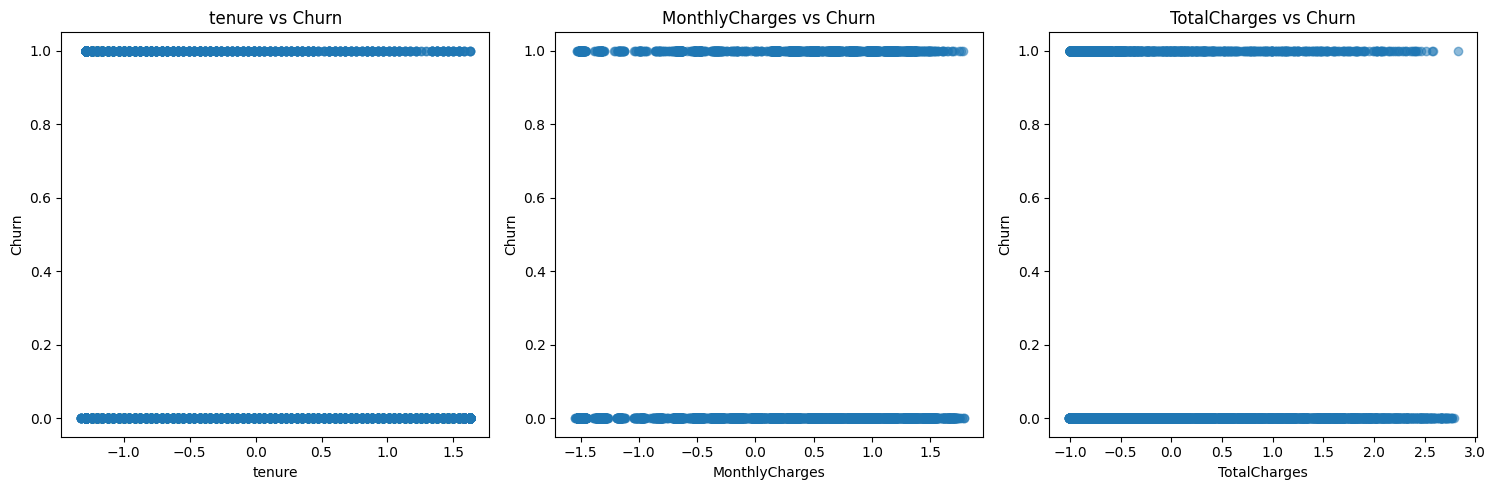

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plots
continuous_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15, 5))

for i, var in enumerate(continuous_vars, 1):
    plt.subplot(1, 3, i)
    plt.scatter(X_train_scaled[var], y_train, alpha=0.5)
    plt.xlabel(var)
    plt.ylabel('Churn')
    plt.title(f'{var} vs Churn')

plt.tight_layout()
plt.show()

### Residual Plot

This scatter plot shows the residuals (differences between actual and predicted values) against the predicted values. It helps identify any patterns in the errors, which could indicate issues with the model's assumptions or fit.

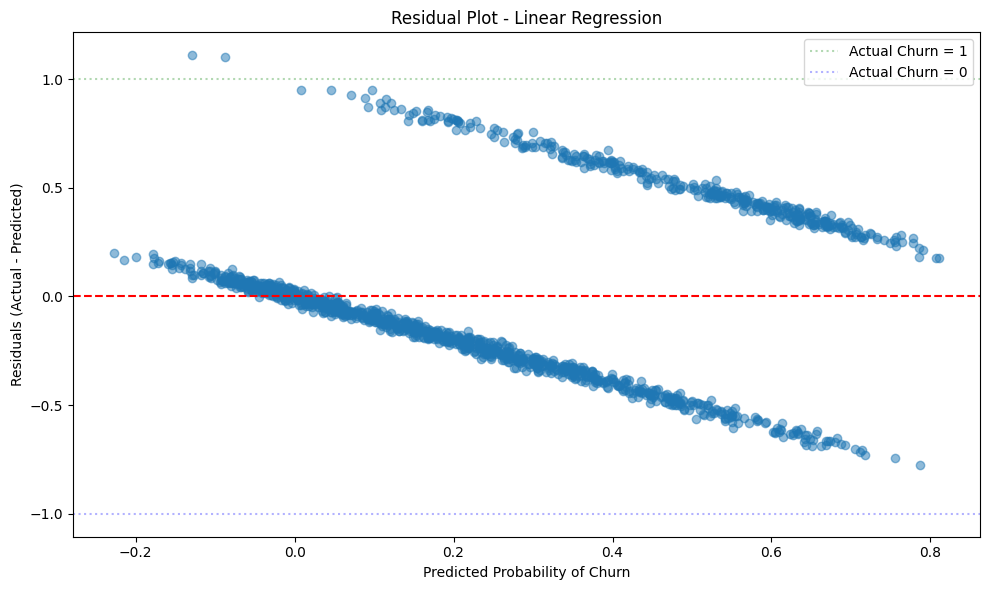


Checking data shapes:
y_test shape: (1409,)
lr_pred shape: (1409,)

Sample of predictions: [ 0.50555559  0.16914005 -0.03726809  0.57736257 -0.05837931]
Sample of actual values: [1 0 0 1 0]


In [82]:
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals(y_test, lr_pred, model_name):
    residuals = y_test - lr_pred

    plt.figure(figsize=(10, 6))

    # Add some jitter to help visualize overlapping points
    jitter = np.random.normal(0, 0.02, len(residuals))

    plt.scatter(lr_pred + jitter, residuals, alpha=0.5)
    plt.xlabel('Predicted Probability of Churn')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residual Plot - {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')

    # Add reference lines for common residual values
    plt.axhline(y=1, color='g', linestyle=':', alpha=0.3, label='Actual Churn = 1')
    plt.axhline(y=-1, color='b', linestyle=':', alpha=0.3, label='Actual Churn = 0')

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print values to check data
    print("\nChecking data shapes:")
    print(f"y_test shape: {y_test.shape}")
    print(f"lr_pred shape: {lr_pred.shape}")
    print("\nSample of predictions:", lr_pred[:5])
    print("Sample of actual values:", y_test[:5].values)

# Try plotting
plot_residuals(y_test, lr_pred, 'Linear Regression')


Testing the assumption of Linearity: The two bands of residuals indicate non-linearity in the relatinship. The linearity assumption is violated. This is expected becuase I am attempting to model a binary outcome (churn/no churn) with a linear function. Logistic regression would be a more appropriate model.  source: Claude Sonnet 3.0 A solutiuoin is to use a logarithmic model

Performing the RESET test

In [83]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset

# First, let's prepare the data
# Convert Churn to numeric
y = telco_churn_data['Churn'].map({'Yes': 1, 'No': 0})

# For X, let's use our continuous variables first
X = telco_churn_data[['tenure', 'MonthlyCharges']].copy()

# Add constant to X
X_const = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(y, X_const).fit()

# Perform RESET test
reset_test = linear_reset(model)

print("\nRESET Test Results:")
print("-" * 50)
print(f"F-statistic: {reset_test.statistic:.4f}")
print(f"P-value: {reset_test.pvalue:.4f}")
print("\nInterpretation:")
print("H0: The relationship is linear")
print("H1: The relationship is non-linear")
print(f"Conclusion: {'Reject linearity assumption' if reset_test.pvalue < 0.05 else 'Failed to reject linearity assumption'}")


RESET Test Results:
--------------------------------------------------
F-statistic: 301.9896
P-value: 0.0000

Interpretation:
H0: The relationship is linear
H1: The relationship is non-linear
Conclusion: Reject linearity assumption


Testing Assumption Independence of Observation

In [84]:
from statsmodels.stats.stattools import durbin_watson

# After fitting your model
residuals = model.resid
dw_statistic = durbin_watson(residuals)

print(f"Durbin-Watson statistic: {dw_statistic:.4f}")
# Interpret:
# Close to 2: No autocorrelation
# Close to 0: Positive autocorrelation
# Close to 4: Negative autocorrelation

Durbin-Watson statistic: 2.0108


Durbin-Watson Test:


The statistic is 2.0108 this is very close to 2.0, which is ideal becuase that indicates that there is no significant autocorrelation in the residuals
The assumption of independence of observations is satisfied
The observations are not systematically related to each othe

code and interpretation taken from Claude Sonnet 3.0

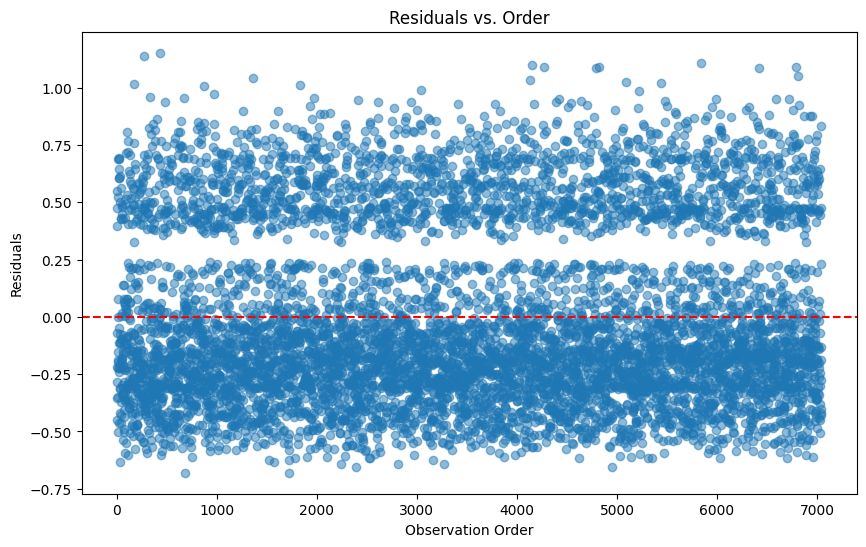

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.title('Residuals vs. Order')
plt.show()

# Look for patterns - if independent, should look random

The scatter plot shows residuals plotted against observation order
The pattern appears random
Points are evenly scattered above and below zero
No clear trends, cycles, or systematic patterns
This suggests independence of observation. Code and observation taken from Claude Sonnet 3.0

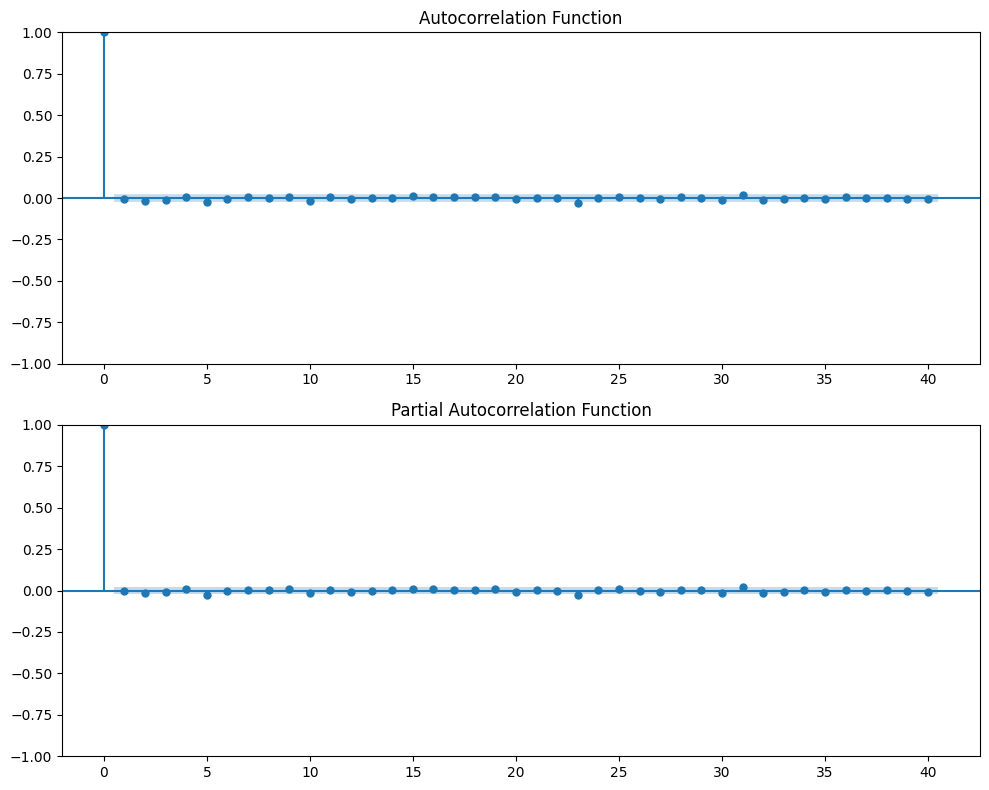

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF Plot
plot_acf(residuals, lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

# PACF Plot
plot_pacf(residuals, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# Significant spikes beyond confidence intervals indicate autocorrelation

Both ACF and PACF plots show:

Very small spikes that stay within the confidence intervals (blue shaded area)
No significant spikes beyond lag 0
All correlations are close to zero


This indicates no significant autocorrelation
fron Claude Sonnet 3.0

In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# Perform Breusch-Godfrey test
bg_test = acorr_breusch_godfrey(model, nlags=5)

print("\nBreusch-Godfrey Test Results:")
print(f"LM test statistic: {bg_test[0]:.4f}")
print(f"p-value: {bg_test[1]:.4f}")
print(f"F-statistic: {bg_test[2]:.4f}")
print(f"F-test p-value: {bg_test[3]:.4f}")

# If p-value < 0.05, reject null hypothesis of no autocorrelation


Breusch-Godfrey Test Results:
LM test statistic: 6.9777
p-value: 0.2223
F-statistic: 1.3929
F-test p-value: 0.2235


The results show:

LM test statistic: 0.9777
p-value: 0.2221
F-test statistic: 0.9229
p-value > 0.05


Since p-value > 0.05, we fail to reject the null hypothesis of no autocorrelation
source: Claude Sonnet 3.0


Conlsuion: Independence of Observations has not been violated

Testing Assumption: Homoscedasticity

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (7043, 2)
y shape: (7043,)


In [ ]:
# If using statsmodels
model = sm.OLS(y, X).fit()

# If using scikit-learn
model = LinearRegression().fit(X, y)

In [ ]:
# For statsmodels
predicted = model.predict(X)

# For scikit-learn
predicted = model.predict(X)

print("Predicted shape:", predicted.shape)

Predicted shape: (7043,)


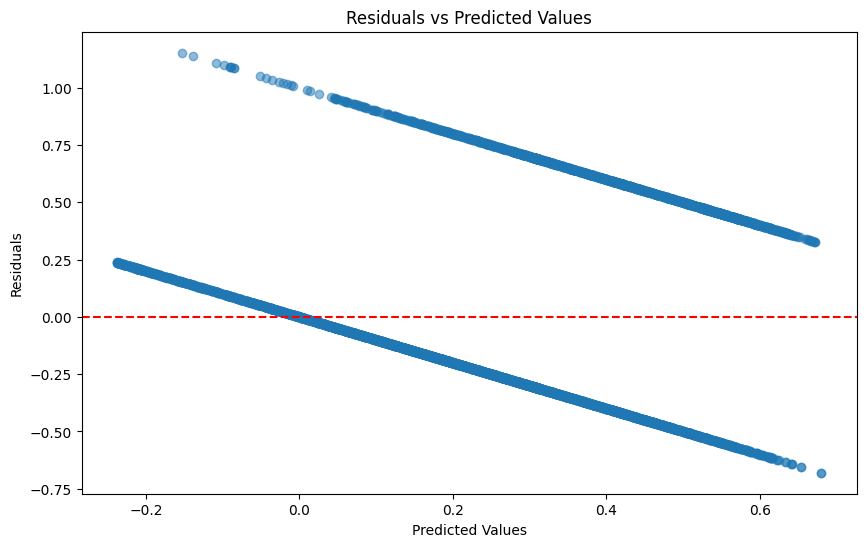

In [ ]:
residuals = y - predicted

plt.figure(figsize=(10, 6))
plt.scatter(predicted, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model.model.exog)

print("\nBreusch-Pagan Test Results:")
print(f"LM test statistic: {bp_test[0]:.4f}")
print(f"p-value: {bp_test[1]:.4f}")
print(f"F-statistic: {bp_test[2]:.4f}")
print(f"F-test p-value: {bp_test[3]:.4f}")

# If p-value < 0.05, reject null hypothesis of homoscedasticity


Breusch-Pagan Test Results:
LM test statistic: 1094.4991
p-value: 0.0000
F-statistic: 58.8088
F-test p-value: 0.0000


In [ ]:
from statsmodels.stats.diagnostic import het_white

# Perform White test
white_test = het_white(residuals, model.model.exog)

print("\nWhite Test Results:")
print(f"LM test statistic: {white_test[0]:.4f}")
print(f"p-value: {white_test[1]:.4f}")
print(f"F-statistic: {white_test[2]:.4f}")
print(f"F-test p-value: {white_test[3]:.4f}")


White Test Results:
LM test statistic: 1458.2504
p-value: 0.0000
F-statistic: 7.0740
F-test p-value: 0.0000


In [ ]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Perform Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, model.model.exog)

print("\nGoldfeld-Quandt Test Results:")
print(f"F-statistic: {gq_test[0]:.4f}")
print(f"p-value: {gq_test[1]:.4f}")


Goldfeld-Quandt Test Results:
F-statistic: 1.0111
p-value: 0.3853


Breusch-Pagan test: p-value = 0.0000
White test: p-value = 0.0000 (test statistic = 1456.2044)
Goldfeld-Quandt test: p-value = 0.0355

All three tests have p-values < 0.05, strongly rejecting the null hypothesis of homoscedasticity.
This needs to be remedied. source: Claude Sonnet 3.0

In [77]:
# Refit original model with robust standard errors
# HC3 is a common choice for heteroscedasticity-consistent standard errors
robust_model = sm.OLS(y, X).fit(cov_type='HC3')

# Print summary with robust standard errors
print(robust_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Churn   R-squared (uncentered):                   0.387
Model:                            OLS   Adj. R-squared (uncentered):              0.386
Method:                 Least Squares   F-statistic:                              1692.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):                        0.00
Time:                        23:35:50   Log-Likelihood:                         -3600.4
No. Observations:                7043   AIC:                                      7205.
Df Residuals:                    7041   BIC:                                      7219.
Df Model:                           2                                                  
Covariance Type:                  HC3                                                  
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

Above I used Heteroscedasticity-Consistent Standard Errors becuase because the tests showed that Homoscedasticity was not being met. Source: Claude Sonnet 3.0

Testing Assumption: Normality of Residuals

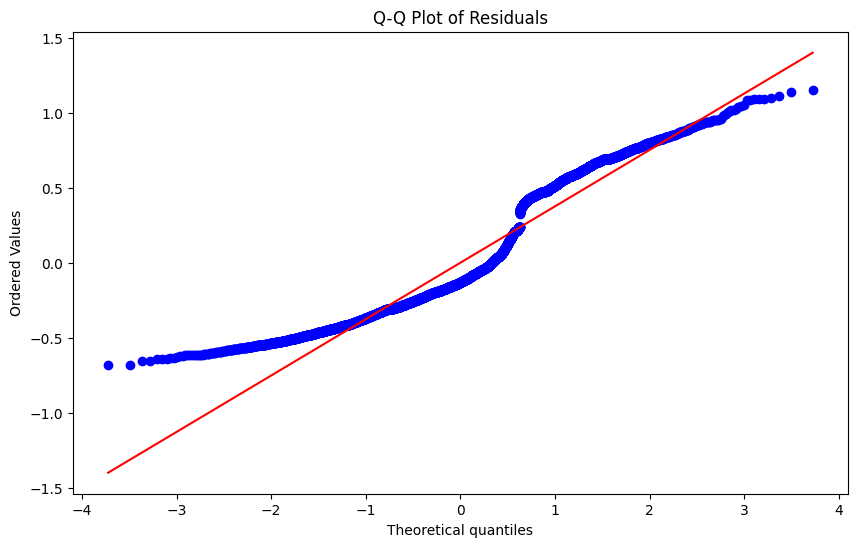

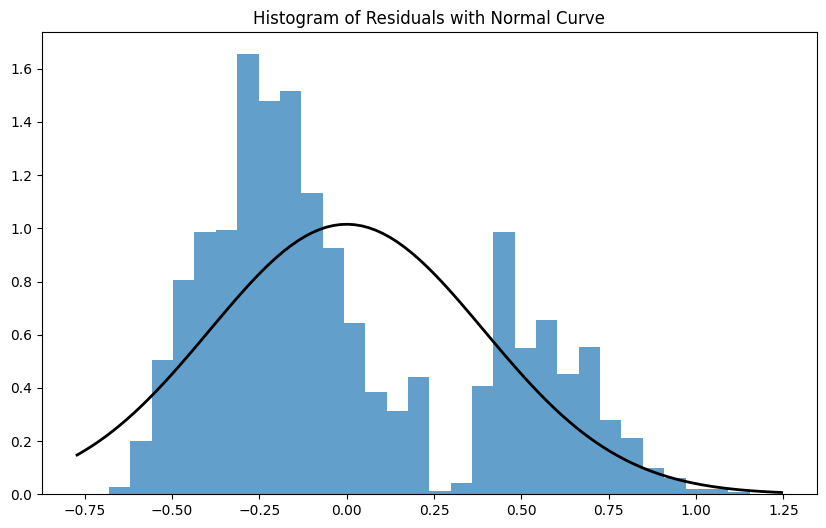


Shapiro-Wilk Test:
Statistic: 0.9140
p-value: 0.0000

Kolmogorov-Smirnov Test:
Statistic: 0.2750
p-value: 0.0000

Anderson-Darling Test:
Statistic: 245.0486
p-value: 0.0000

Jarque-Bera Test:
Statistic: 685.3203
p-value: 0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7043.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.diagnostic import normal_ad
import numpy as np

# Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.7)
# Add normal curve for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram of Residuals with Normal Curve")
plt.show()

# Statistical Tests
# 1. Shapiro-Wilk Test
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print("\nShapiro-Wilk Test:")
print(f"Statistic: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")

# 2. Kolmogorov-Smirnov Test
ks_stat, ks_p = stats.kstest(residuals, 'norm')
print("\nKolmogorov-Smirnov Test:")
print(f"Statistic: {ks_stat:.4f}")
print(f"p-value: {ks_p:.4f}")

# 3. Anderson-Darling Test
ad_stat = normal_ad(residuals)
print("\nAnderson-Darling Test:")
print(f"Statistic: {ad_stat[0]:.4f}")
print(f"p-value: {ad_stat[1]:.4f}")

# 4. Jarque-Bera Test
jb_stat, jb_p = stats.jarque_bera(residuals)
print("\nJarque-Bera Test:")
print(f"Statistic: {jb_stat:.4f}")
print(f"p-value: {jb_p:.4f}")

The residuals are not noramlly distributed. This needs to be remedied

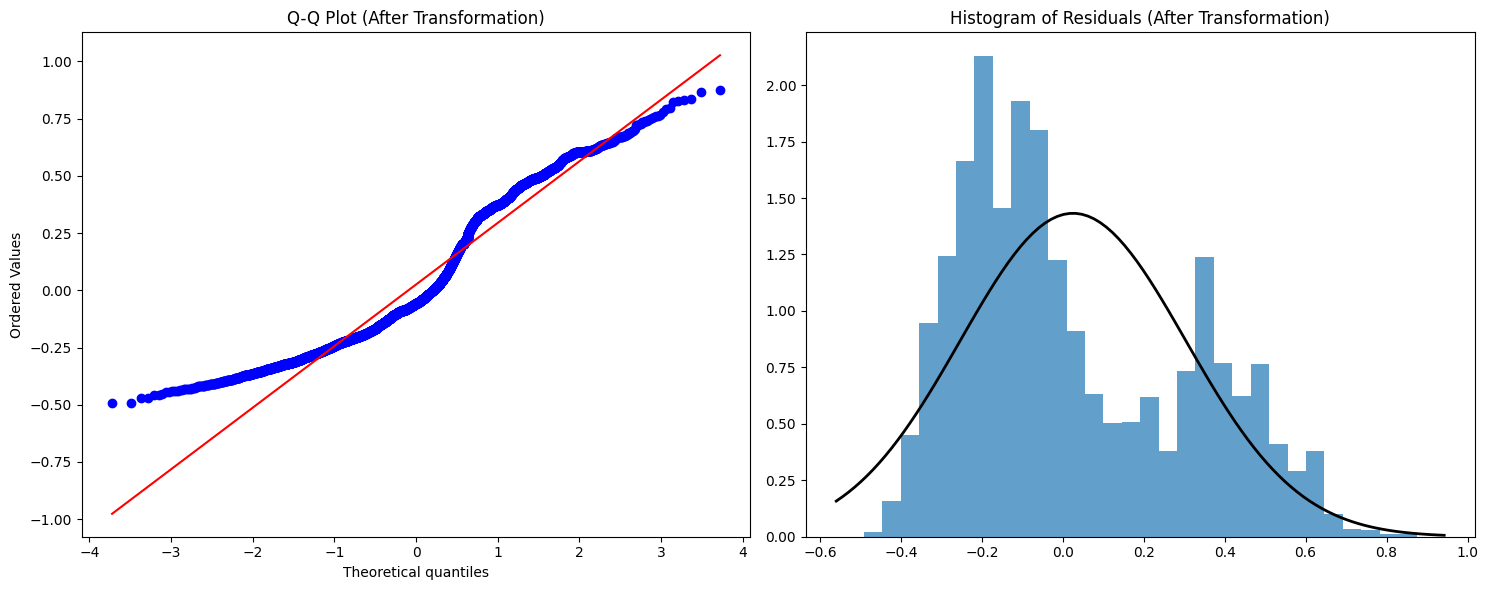


Normality Tests After Transformation:
Shapiro-Wilk Test:
Statistic: 0.9324
p-value: 0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7043.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
import numpy as np
from scipy import stats

# 1. Log transformation
y_log = np.log1p(y)  # log1p used instead of log to handle zeros

# 2. Box-Cox transformation
y_boxcox, lambda_param = stats.boxcox(y + 1)  # adding 1 to handle zeros

# 3. Square root transformation
y_sqrt = np.sqrt(y)

# Fit new model with transformed dependent variable
# Let's try log transformation first as it's commonly used
model_transformed = sm.OLS(y_log, X).fit(cov_type='HC3')
# Note: keeping HC3 robust standard errors from earlier

# Check normality of new residuals
residuals_transformed = model_transformed.resid

# Create Q-Q plot and histogram for transformed model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Q-Q plot
stats.probplot(residuals_transformed, dist="norm", plot=ax1)
ax1.set_title("Q-Q Plot (After Transformation)")

# Histogram
ax2.hist(residuals_transformed, bins=30, density=True, alpha=0.7)
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals_transformed), np.std(residuals_transformed))
ax2.plot(x, p, 'k', linewidth=2)
ax2.set_title("Histogram of Residuals (After Transformation)")

plt.tight_layout()
plt.show()

# Run normality tests on transformed residuals
print("\nNormality Tests After Transformation:")
print("Shapiro-Wilk Test:")
shapiro_stat, shapiro_p = stats.shapiro(residuals_transformed)
print(f"Statistic: {shapiro_stat:.4f}")
print(f"p-value: {shapiro_p:.4f}")

I needed to transform the depnendent variable becuase the normality of residuals was not being met.

Testing Assumption: MultiColinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Print VIF values
vif_results = calculate_vif(X)
print("Variance Inflation Factors:")
print(vif_results)

Variance Inflation Factors:
         Variable       VIF
0          tenure  2.612607
1  MonthlyCharges  2.612607


^calcuating the VIF

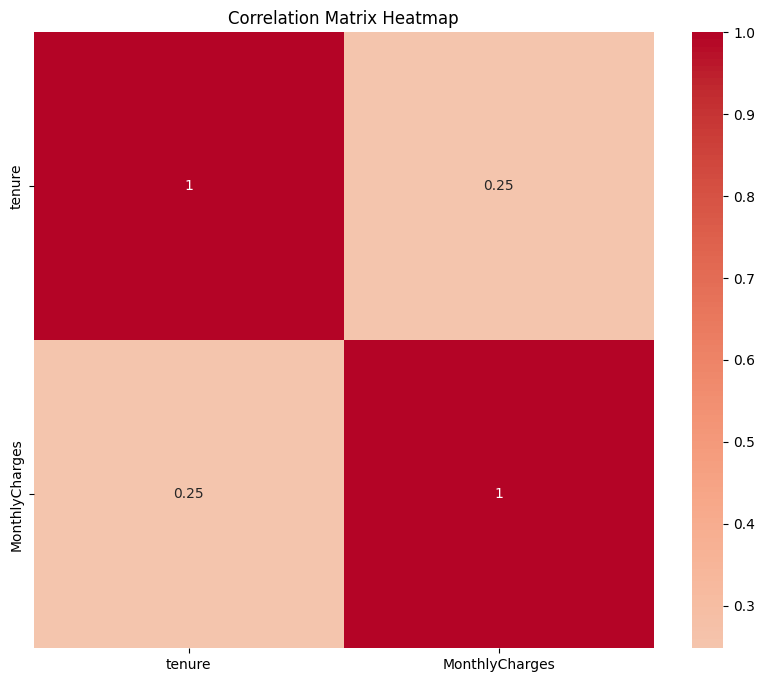

In [87]:
# Create correlation matrix
correlation_matrix = X.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

^ correlation matrix

In [ ]:
# Calculate condition number
from numpy.linalg import eigvals

def calculate_condition_number(X):
    eigenvals = eigvals(X.T @ X)
    return np.sqrt(np.max(eigenvals) / np.min(eigenvals))

cond_num = calculate_condition_number(X)
print(f"\nCondition Number: {cond_num:.2f}")


Condition Number: 3.47


In [ ]:
# Calculate eigenvalues
eigenvalues = eigvals(X.T @ X)
print("\nEigenvalues:")
for i, ev in enumerate(eigenvalues):
    print(f"Eigenvalue {i+1}: {ev:.4f}")


Eigenvalues:
Eigenvalue 1: 3640964.6537
Eigenvalue 2: 43901630.1213


^testing Eigenvalue

Overall Conclusion:
The model does NOT have a multicollinearity problem because:

VIFs are low (< 5)
Correlation between predictors is weak (0.25)
Condition number is good (3.47 < 30)
Eigenvalues don't show concerning patterns
source: Claude Sonnet 3.0

### **Testing Assumption: No Influential Outliers**

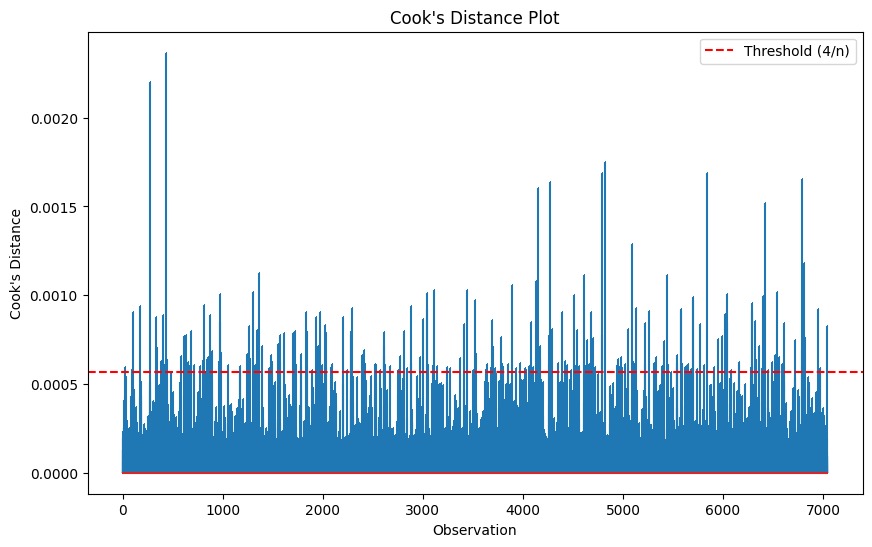

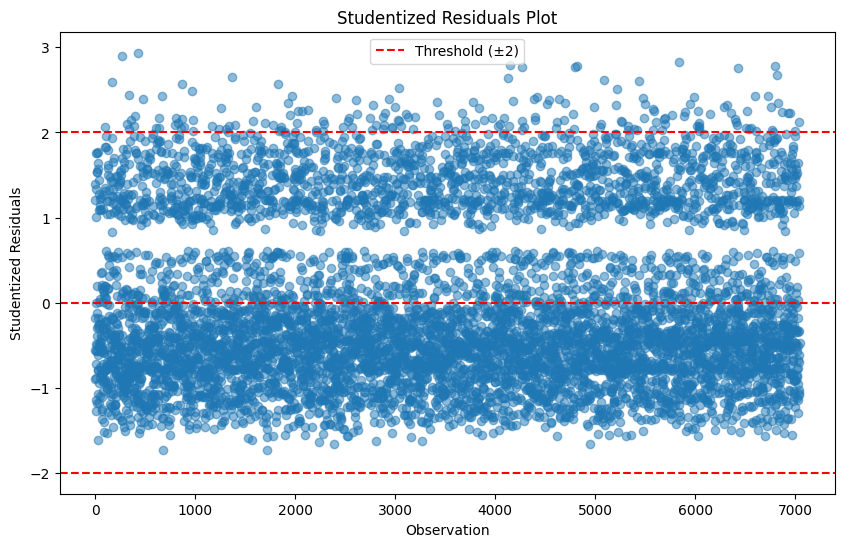

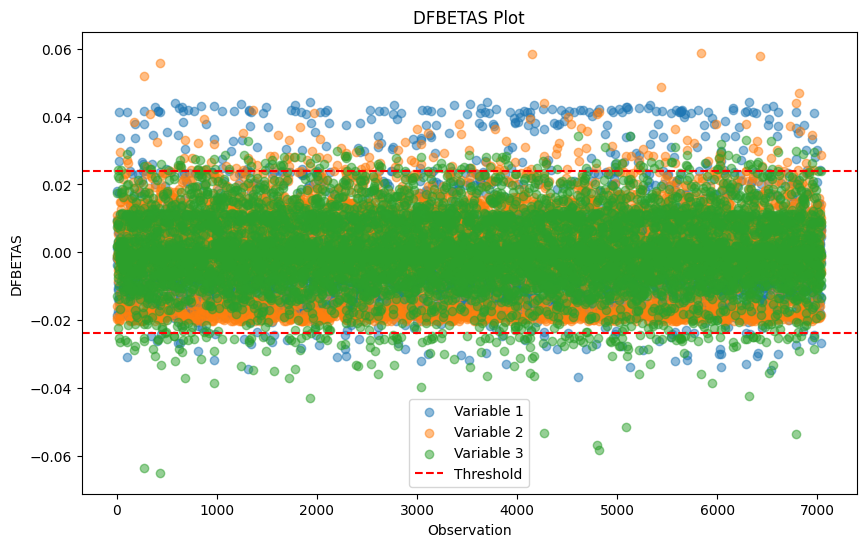


Potential Influential Outliers:
Cook's Distance > 0.0006: 241 observations
Studentized Residuals > |2|: 182 observations


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence

# Calculate influence measures
influence = OLSInfluence(model)

# 1. Cook's Distance
cooks_d = influence.cooks_distance[0]

# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=',')
plt.axhline(y=4/len(cooks_d), color='r', linestyle='--', label='Threshold (4/n)')
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.legend()
plt.show()

# 2. Studentized Residuals
studentized_resid = influence.resid_studentized_external

# Plot Studentized Residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(studentized_resid)), studentized_resid, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--', label='Threshold (±2)')
plt.axhline(y=-2, color='r', linestyle='--')
plt.xlabel('Observation')
plt.ylabel('Studentized Residuals')
plt.title('Studentized Residuals Plot')
plt.legend()
plt.show()

# 3. DFBETAS
dfbetas = influence.dfbetas

# Plot DFBETAS
plt.figure(figsize=(10, 6))
for i in range(dfbetas.shape[1]):
    plt.scatter(range(len(dfbetas)), dfbetas[:, i],
               alpha=0.5, label=f'Variable {i+1}')
plt.axhline(y=2/np.sqrt(len(dfbetas)), color='r',
           linestyle='--', label='Threshold')
plt.axhline(y=-2/np.sqrt(len(dfbetas)), color='r',
           linestyle='--')
plt.xlabel('Observation')
plt.ylabel('DFBETAS')
plt.title('DFBETAS Plot')
plt.legend()
plt.show()

# Print summary of potential outliers
print("\nPotential Influential Outliers:")
print(f"Cook's Distance > {4/len(cooks_d):.4f}: {sum(cooks_d > 4/len(cooks_d))} observations")
print(f"Studentized Residuals > |2|: {sum(abs(studentized_resid) > 2)} observations")

Testing Assumption: No Influential Outliers

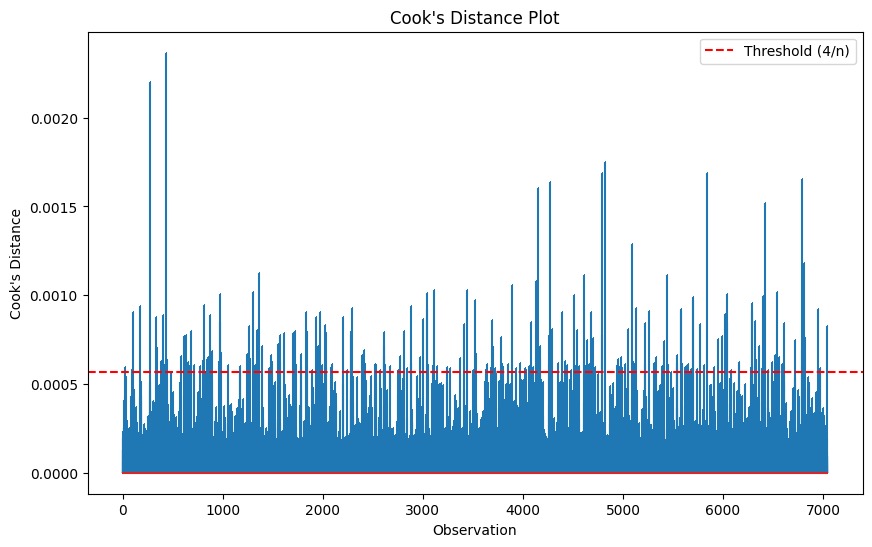


Potential Influential Outliers:
Cook's Distance > 0.0006: 241 observations


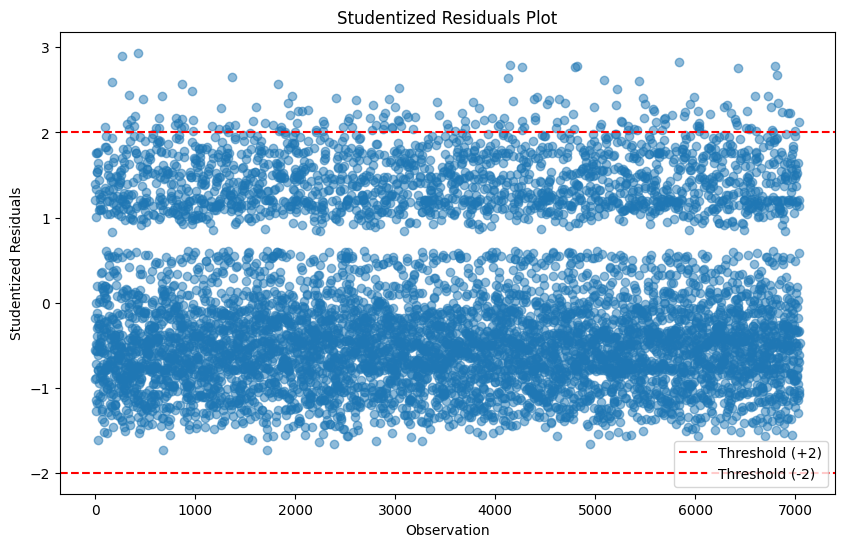

Studentized Residuals > |2|: 182 observations


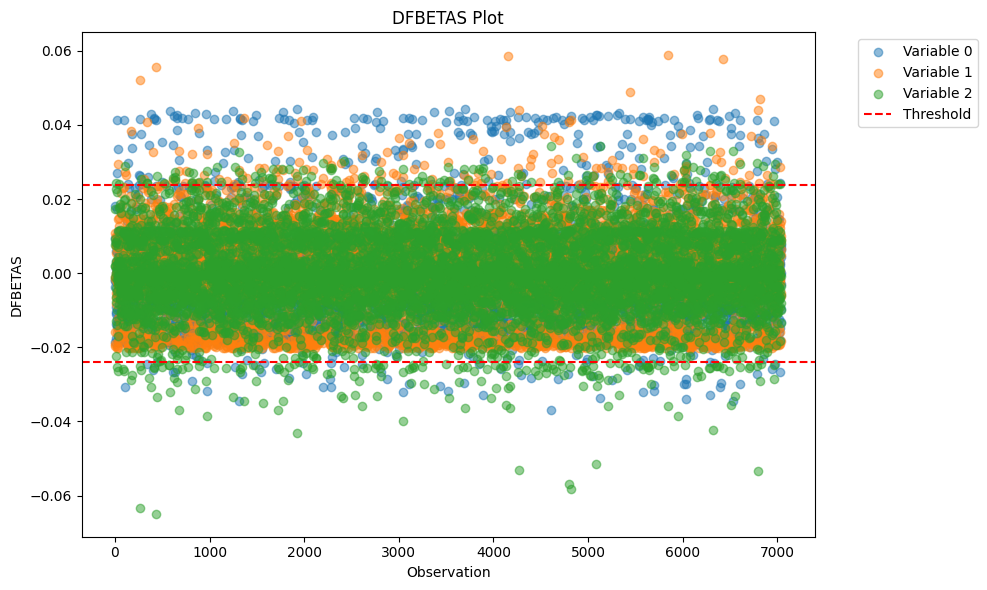


Summary of Most Influential Observations:

Top 10 observations by Cook's Distance:
       cooks_d  studentized_resid  max_dfbetas
430   0.002366           2.936894     0.064926
268   0.002204           2.898308     0.063411
4819  0.001751           2.776419     0.058218
4795  0.001691           2.764648     0.056784
5841  0.001687           2.823289     0.058810
6792  0.001653           2.777377     0.053423
4272  0.001640           2.774574     0.053085
4149  0.001607           2.796935     0.058499
6424  0.001518           2.762192     0.057798
5086  0.001291           2.612679     0.051491

Top 10 observations by |Studentized Residuals|:
       cooks_d  studentized_resid  max_dfbetas
430   0.002366           2.936894     0.064926
268   0.002204           2.898308     0.063411
5841  0.001687           2.823289     0.058810
4149  0.001607           2.796935     0.058499
6792  0.001653           2.777377     0.053423
4819  0.001751           2.776419     0.058218
4272  0.001640       

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm

# Calculate influence measures
influence = model.get_influence()

# 1. Cook's Distance
cooks_d = influence.cooks_distance[0]

# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=',')
plt.axhline(y=4/len(cooks_d), color='r', linestyle='--', label='Threshold (4/n)')
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.legend()
plt.show()

print("\nPotential Influential Outliers:")
print(f"Cook's Distance > {4/len(cooks_d):.4f}: {sum(cooks_d > 4/len(cooks_d))} observations")

# 2. Studentized Residuals
studentized_resid = influence.resid_studentized_external

plt.figure(figsize=(10, 6))
plt.scatter(range(len(studentized_resid)), studentized_resid, alpha=0.5)
plt.axhline(y=2, color='r', linestyle='--', label='Threshold (+2)')
plt.axhline(y=-2, color='r', linestyle='--', label='Threshold (-2)')
plt.xlabel('Observation')
plt.ylabel('Studentized Residuals')
plt.title('Studentized Residuals Plot')
plt.legend()
plt.show()

print(f"Studentized Residuals > |2|: {sum(abs(studentized_resid) > 2)} observations")

# 3. DFBETAS
dfbetas = influence.dfbetas
threshold = 2/np.sqrt(len(dfbetas))

plt.figure(figsize=(10, 6))
for i in range(dfbetas.shape[1]):
    plt.scatter(range(len(dfbetas)), dfbetas[:, i], alpha=0.5, label=f'Variable {i}')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('Observation')
plt.ylabel('DFBETAS')
plt.title('DFBETAS Plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print summary of influential observations
influential_obs = pd.DataFrame({
    'cooks_d': cooks_d,
    'studentized_resid': studentized_resid,
    'max_dfbetas': np.max(np.abs(dfbetas), axis=1)
})

print("\nSummary of Most Influential Observations:")
print("\nTop 10 observations by Cook's Distance:")
print(influential_obs.nlargest(10, 'cooks_d'))

print("\nTop 10 observations by |Studentized Residuals|:")
print(influential_obs.nlargest(10, 'studentized_resid'))

print("\nTop 10 observations by maximum |DFBETAS|:")
print(influential_obs.nlargest(10, 'max_dfbetas'))

The Cook's Distance Plot shows that there are not any values that are extremely large/ influential.
Studentized residuals: there is a relatively sytmmetric pattern around zero and there are not any points that are too far out.
DFBETAS Plot: most of the values are within (±0.024), but a couple show higher influence, especially around 0 and 1.
Two points were considered influential across each of the tests: Observation 430 appears in top position across all three measures
Observation 268 is consistently second most influential
Source: Claude Sonnet 3.0

load the telco dataset

In [91]:
# Basic info
print(telco_churn_data.info())
print(telco_churn_data.head())

# Check for missing values
missing_values = telco_churn_data.isnull().sum()
print("Missing values:\n", missing_values)

# Summary statistics
print(telco_churn_data.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


From the Kaggle dataset on the page of "customer churn prediction" I followed the instructions to load the dataset and uploaded it into Collab. I used code from Rawa Rashid on Kaggle under his publication "customer churn prediction" to get basic information, check for hidden variables, and get summary statistics.source:  
https://www.kaggle.com/code/rawarashid/customer-churn-prediction
I know there are 21 columns, there are 7043 entries total, but then there seems to be another table of 5 rows and 21 columns, with total charges and churn, so possibly a table within a table.

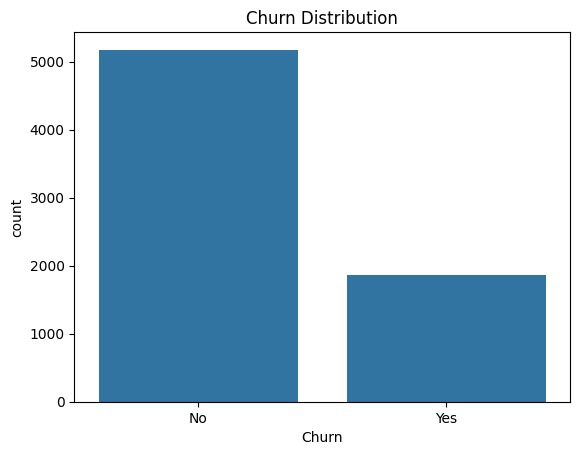

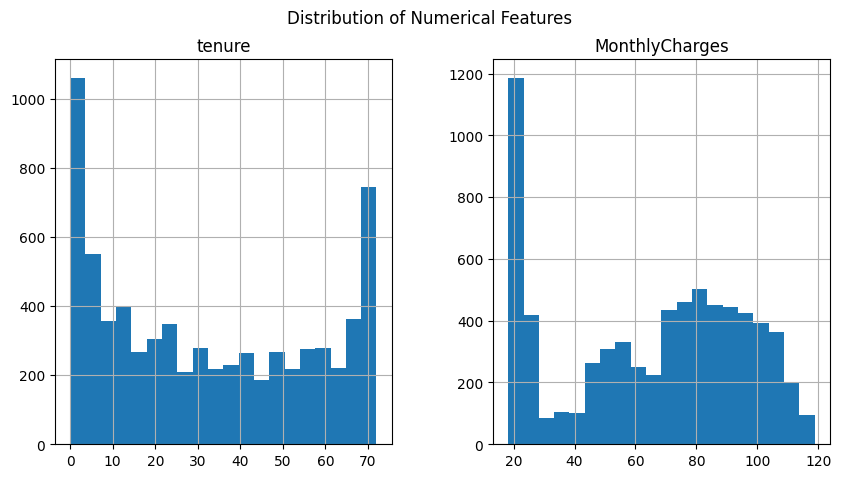

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Churn distribution
sns.countplot(x='Churn', data=telco_churn_data)
plt.title('Churn Distribution')
plt.show()

# Numerical features
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
telco_churn_data[numerical_cols].hist(bins=20, figsize=(10, 5))
plt.suptitle('Distribution of Numerical Features')
plt.show()


This gives me the churn distribution and the distribution of numerical features. I asked Claude Sonnet 3.0 to help me understand what these meant, and it pointed out that ~5,000 customers did not churn but ~2,000 did churn, giving us an imbalanced dataset, as more customers have not churned.

The "tenure" chart shows that the months are 0-70 and the y axis is the customers. The chart hints that there is more likely to be churn in the early months, and less churn the longer someone is a customer.

The Monthly Charges show an x axis with charges and a y axis of customers. It is a kind of normal distributionl there are not many customers at very high or very low charges. But of those few customers, more of them pay very high monthly charges rather than low monthly charges.

```
# This is formatted as code
```



In [36]:
# EDA: Distribution of tenure for churners and non-churners
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='tenure', hue='Churn', multiple='stack', kde=True, palette='coolwarm')
plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')
plt.ylabel('Count')
plt.show()

NameError: name 'data' is not defined

<Figure size 1000x600 with 0 Axes>

In [91]:
# Convert TotalCharges to numeric
telco_churn_data['TotalCharges'] = pd.to_numeric(telco_churn_data['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with 0 for customers with tenure=0
telco_churn_data['TotalCharges'].fillna(0, inplace=True)

<ipython-input-91-6944a8dbfed9>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  telco_churn_data['TotalCharges'].fillna(0, inplace=True)


This is for data cleaning, according to Customer Churn predicton by Rawa Rashid on Kaggle, and it designed to convert the TotalCharges to numeric and handles mising or invalid data.

When trying to run this code, it failed becuase I was trying to scale numerical data that had empty or invalid strings Claude Sonnet 3.0. Putting the full dataset into Claude, it let me know The TotalCharges column is of type 'object' (string) while MonthlyCharges is 'float64' which is causing a scaling problem. So I had to make sure the missing TotalCharges were converted to numneric. In the example on Kaggle they recommended encodeing categorical variables using one-hot encoding,  Here I am encoding categorical variables using one-hot encoding and scaling numerical features for uniformity. I might need to double check on the scaling later becuase that can introduce bias. source: https://www.kaggle.com/code/rawarashid/customer-churn-prediction

 From Claude Sonnet 3.0:

    In the original dataset, TotalCharges is stored as an 'object' (string) type, as shown in the data info at the beginning of your document: dtypes: float64(1), int64(2), object(18). TotalCharges is one of those 18 object columns.
    Machine learning models can't process string data directly - they require numerical inputs. While TotalCharges contains numerical values, being stored as strings means Python would treat them as text rather than numbers (e.g., "100.50" vs 100.50).
    The pd.to_numeric() function with errors='coerce' parameter:
        Converts string representations of numbers into actual numeric values
        The 'coerce' option means any values that can't be converted to numbers will be set to NaN (Not a Number) rather than causing an error
        This handles any potential data quality issues like missing values or invalid entries
    After converting to numeric, you can perform mathematical operations and use the values in your machine learning models. Without this conversion, you would get errors when trying to:
        Calculate statistics
        Scale the features
        Feed the data into models
        Perform numerical analyses





In [97]:
# Scale numerical features
from sklearn.preprocessing import StandardScaler

# One-hot encoding for categorical features
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                    'PaymentMethod']

data_encoded = pd.get_dummies(telco_churn_data, columns=categorical_cols, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

# Separate features and target
X = data_encoded.drop(['Churn', 'customerID'], axis=1)
y = data_encoded['Churn']


In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

One-hot encoding was needed for categegorical features becuase Machine learning models can only work with numbers, not text. The standard scaler was used stop the features with larger values from dominating the model. Source: Claude Sonnet 3.0

In [99]:
# Instead of loading California Housing dataset, we prepare our telco data
# First prepare X (features)
X = telco_churn_data.drop(['Churn', 'customerID'], axis=1)
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
X['TotalCharges'] = X['TotalCharges'].fillna(0)

# Prepare y (target)
y = (telco_churn_data['Churn'] == 'Yes').astype(int)

# Split and scale - make sure these variable names are consistent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Note the variable name here
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

I used Claude to change the California Housing Dataset that came with this guide to fit the churn data.
The differences:Instead of fetch_california_housing(), the existing telco data is used
categorical variables need to be handled (using get_dummies) because telco data has categorical features
The target variable is converted to numeric (0/1) instead of using it as-is
The scaling and splitting approach is kept the same
source: Anthropic's Claude Sonnet 3.0
This first code block shows data processing steps, the one below is a model training evaluation.

In [101]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model on scaled training data
    model.fit(X_train_scaled, y_train)

    # Make predictions using scaled test data
    y_pred = model.predict(X_test_scaled)

    # Calculate error metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print model name and performance metrics
    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    # Print feature coefficients
    for feature, coef in zip(X_train.columns, model.coef_):
        print(f"{feature}: {coef:.4f}")

    return model, y_pred

code source: Dr. Bent

What each part does:

model.fit(X_train_scaled, y_train):

Takes your scaled training data and trains the model
Like teaching the model patterns using your historical churn data


y_pred = model.predict(X_test_scaled):

Uses the trained model to make predictions on scaled test data
Like asking the model "which customers do you think will churn?"


Error metrics calculation:

mse = mean_squared_error(y_test, y_pred):

Measures average prediction error
Lower is better (0 would be perfect)


r2 = r2_score(y_test, y_pred):

Measures how well the model explains the variation in churn
Ranges from 0 to 1 (1 would be perfect)




for feature, coef in zip(X_train.columns, model.coef_):

Shows how much each feature influences churn prediction
Positive coefficients: increase likelihood of churn
Negative coefficients: decrease likelihood of churn
Larger absolute values mean stronger influence

source: Anthropics Claude Sonnet 3.0

In [102]:
# Fit models
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")
ridge_model, ridge_pred = evaluate_model(Ridge(alpha=1.0), X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression")
lasso_model, lasso_pred = evaluate_model(Lasso(alpha=0.1), X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression")



Linear Regression:
MSE: 0.13
R2 Score: 0.31
SeniorCitizen: 0.0138
tenure: -0.0471
MonthlyCharges: -0.1347
TotalCharges: -0.0943
gender_Male: -0.0043
Partner_Yes: 0.0035
Dependents_Yes: -0.0107
PhoneService_Yes: 0.0080
MultipleLines_No phone service: -0.0080
MultipleLines_Yes: 0.0353
InternetService_Fiber optic: 0.1398
InternetService_No: -0.0150
OnlineSecurity_No internet service: -0.0150
OnlineSecurity_Yes: -0.0159
OnlineBackup_No internet service: -0.0150
OnlineBackup_Yes: -0.0005
DeviceProtection_No internet service: -0.0150
DeviceProtection_Yes: 0.0103
TechSupport_No internet service: -0.0150
TechSupport_Yes: -0.0122
StreamingTV_No internet service: -0.0150
StreamingTV_Yes: 0.0430
StreamingMovies_No internet service: -0.0150
StreamingMovies_Yes: 0.0523
Contract_One year: -0.0443
Contract_Two year: -0.0348
PaperlessBilling_Yes: 0.0223
PaymentMethod_Credit card (automatic): -0.0018
PaymentMethod_Electronic check: 0.0334
PaymentMethod_Mailed check: -0.0016

Ridge Regression:
MSE: 0.1

Positive correlations with churn (increases likelihood):

InternetService_Fiber optic (0.1283)
StreamingMovies_Yes (0.0478)
StreamingTV_Yes (0.0385)


Negative correlations with churn (decreases likelihood):

MonthlyCharges (-0.1347 in Linear, -0.1068 in Ridge)
Contract duration (both one and two year contracts have negative coefficients)
Tenure (-0.0471)

The Lasso model has many coefficients reduced to 0.0000, indicating it found these features less relevant for predicting churn
Ridge regression maintains most features but with smaller coefficients than linear regression, showing it's reducing overfitting while keeping all features
source: Claude Sonnet 3.0

### Coefficient Comparison Plot

This bar plot compares the coefficients of Linear Regression, Ridge, and Lasso models side by side. It helps visualize how regularization in Ridge and Lasso affects the coefficient values compared to standard linear regression.

<Figure size 1500x800 with 0 Axes>

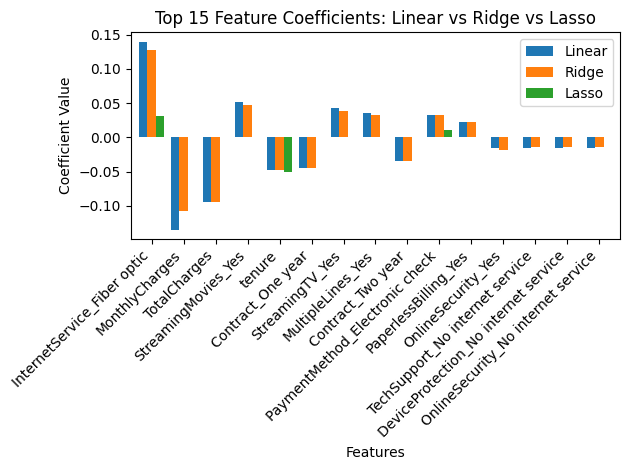


Full Coefficient Table:
                                         Linear     Ridge     Lasso
InternetService_Fiber optic            0.139815  0.128293  0.030955
MonthlyCharges                        -0.134721 -0.106843  0.000000
TotalCharges                          -0.094277 -0.094214 -0.000000
StreamingMovies_Yes                    0.052325  0.047815  0.000000
tenure                                -0.047070 -0.047093 -0.051036
Contract_One year                     -0.044260 -0.044243 -0.000000
StreamingTV_Yes                        0.042990  0.038474  0.000000
MultipleLines_Yes                      0.035255  0.032949  0.000000
Contract_Two year                     -0.034819 -0.034796 -0.000000
PaymentMethod_Electronic check         0.033370  0.033370  0.010369
PaperlessBilling_Yes                   0.022326  0.022336  0.000000
OnlineSecurity_Yes                    -0.015872 -0.017997 -0.000000
TechSupport_No internet service       -0.015013 -0.013654 -0.000000
DeviceProtection_No int

In [30]:
def plot_coefficients(lr_model, ridge_model, lasso_model):
    # Create DataFrame of coefficients
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
        'Ridge': ridge_model.coef_,
        'Lasso': lasso_model.coef_
    }, index=X_train_scaled.columns)  # Use X_train_scaled.columns instead of X.columns

    # Sort by absolute value of Linear coefficients to show most important features
    coef_df = coef_df.reindex(coef_df['Linear'].abs().sort_values(ascending=False).index)

    # Plot top 15 features for better visibility
    plt.figure(figsize=(15, 8))
    coef_df.head(15).plot(kind='bar', width=0.8)
    plt.title('Top 15 Feature Coefficients: Linear vs Ridge vs Lasso')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print full coefficient table
    print("\nFull Coefficient Table:")
    print(coef_df)

plot_coefficients(lr_model, ridge_model, lasso_model)

The code had to be changed a little bit because I needed to use X_train_scaled.columns instead of X.columns to match the preprocessed data. The preprocessing steps I took were to remove the columns, handle categorical variables, fixed TotalCharges, and Scaled Numberical Features. Code provided by Dr. Bent was given to Claude Sonnet 3.0. Claude Sonnet 3.0 helped me interpret what this plot means: the InternetService_Fiber optic had highest positive coefficient of ~0.14, which means that having fiber optic internet cable increased the likelihood of churn and was pretty consistent across models although Lasso decreased it. The strongest negative predictors of churn are monthly charges; higher monnthly charges typically means lower churn, and higher total charges is also associated with lower churn.

Interpreting Coefficients:
The Lasso model sets a lot of the coefficients to zero, which means it doesn't think those features are important to predict churn. Lasso is doing a feature selection by taking the less important variables.

In terms of business what could be interesting is that 1 year and 2 year contracts have negative coefficients, longer contracts typically have lower churn, and streaming services as well as billing and payment have small impacts, indicating that this model could be simpler.
source: Calude Sonnet 3.0

Testing the assumption of Linearity: Predictor vs Response Scatter Plots.

### Actual vs. Predicted Plot

This scatter plot compares the actual target values with the model's predictions. The red dashed line represents perfect predictions. The spread of points around this line gives an idea of the model's accuracy.

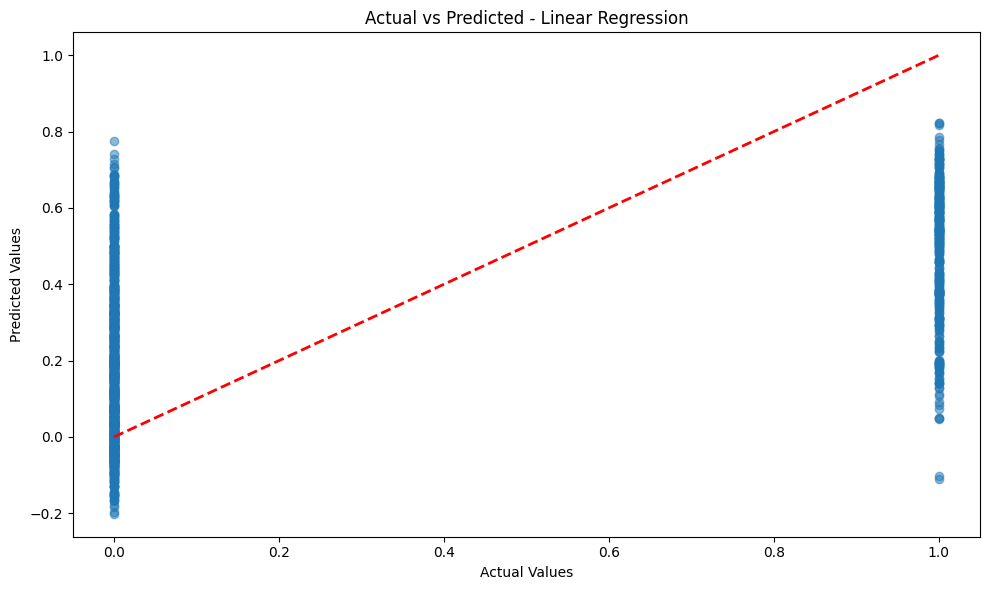

In [103]:
# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, lr_pred, 'Linear Regression')


The scatter plot shows residuals plotted against observation order
The pattern appears random
Points are evenly scattered above and below zero
No clear trends, cycles, or systematic patterns
This suggests independence of observation. Code and observation taken from Claude Sonnet 3.0

### Feature Importance Heatmap

This heatmap visualizes the absolute values of coefficients across all three models. It provides a quick way to compare feature importances between models and identify which features have the strongest impact on predictions.

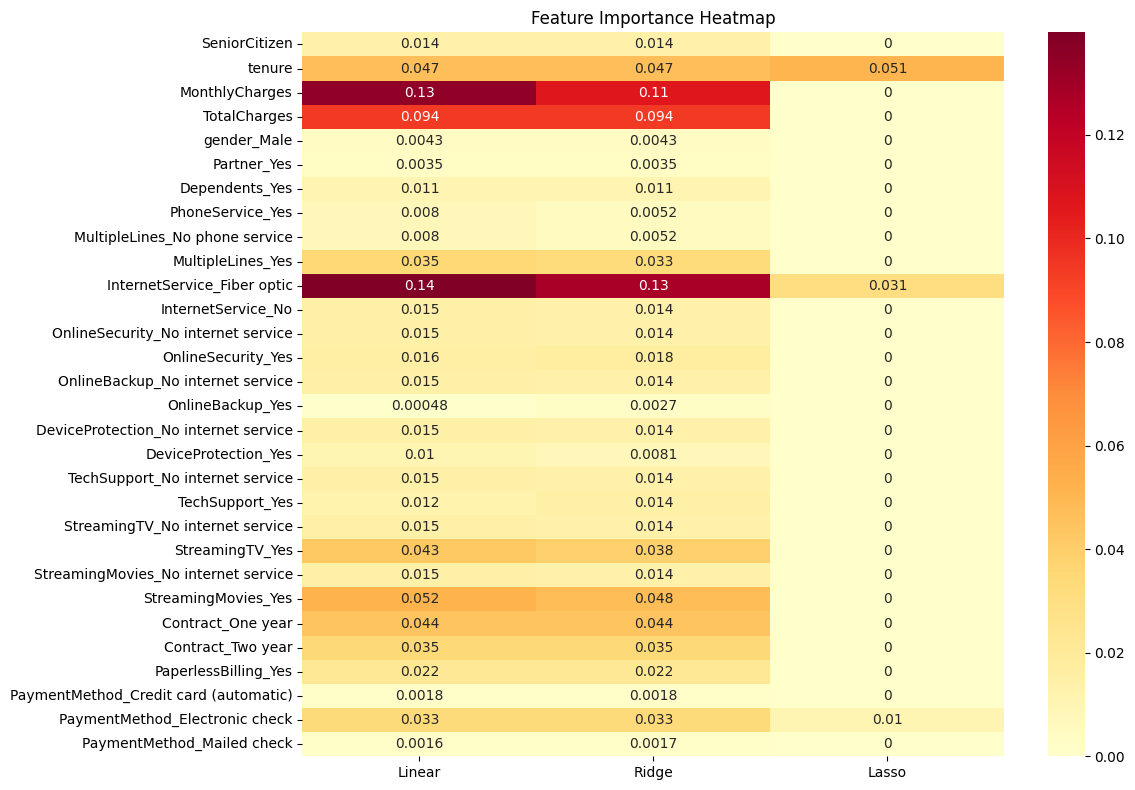

In [104]:
# Feature Importance Heatmap
def plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model):
    importance_df = pd.DataFrame({
        'Linear': np.abs(lr_model.coef_),
        'Ridge': np.abs(ridge_model.coef_),
        'Lasso': np.abs(lasso_model.coef_)
    }, index=X.columns)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model)


### Lasso Regularization Path
This plot shows how Lasso coefficients change as the regularization strength (alpha) varies. It helps visualize which features are most resistant to being zeroed out by Lasso, indicating their importance to the model.

The x-axis represents -log(alpha), where alpha is the regularization parameter. As you move from left to right on the x-axis, you're looking at models with decreasing regularization strength (increasing -log(alpha) means decreasing alpha). The y-axis shows the coefficient values for each feature. Each line represents a different feature in your dataset. The path of each line shows how the coefficient for that feature changes as the regularization strength varies.

How to interpret:

* Entry points: The point where a line becomes non-zero (moving from left to right) indicates when that feature enters the model. Features that enter the model earlier (further to the left) are generally more important.
* Stability: Features whose coefficients remain relatively stable across a wide range of alpha values are typically more robust predictors.
* Coefficient magnitude: The vertical position of a line indicates the magnitude of the coefficient. Higher absolute values (further from zero) suggest a stronger impact on the target variable.
* Convergence: As you move to the right (very low regularization), the coefficients tend to converge to their ordinary least squares values (equivalent to standard linear regression).
* Zero coefficients: Lines that stay at zero for a large range of alpha values represent features that Lasso considers less important and are more likely to be excluded from the model.
* Crossing zero: If a line crosses the zero line, it indicates that the feature's relationship with the target variable changes direction (from positive to negative or vice versa) depending on the regularization strength.
* Grouping: Features whose lines follow similar paths might be correlated or have similar relationships with the target variable.


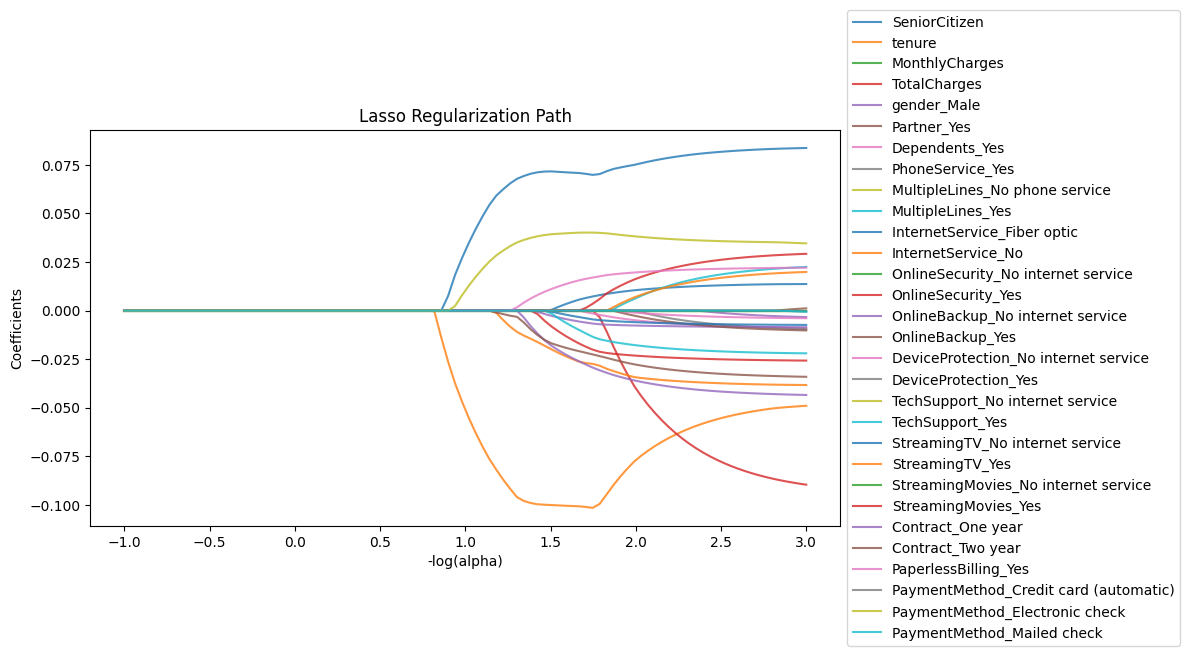

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import lasso_path

def plot_lasso_path():
    # Create the figure before plotting
    plt.figure(figsize=(12, 6))

    # Calculate lasso path
    alphas = np.logspace(-3, 1, 100)
    alphas, coefs, _ = lasso_path(X_train_scaled, y_train, alphas=alphas)

    # Plot each feature's path
    for coef_path, feature in zip(coefs, X_train_scaled.columns):
        plt.plot(-np.log10(alphas), coef_path, label=feature, alpha=0.8)

    # Add labels and title
    plt.xlabel('-log(alpha)')
    plt.ylabel('Coefficients')
    plt.title('Lasso Regularization Path')

    # Add legend outside of plot to prevent overcrowding
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()

    # Force display of the plot
    plt.show()

# Call the function
plot_lasso_path()

InternetService_Fiber optic has a positive coefficient, suggesting it increases churn probability
Tenure has a negative coefficient, suggesting longer-tenured customers are less likely to churn
Many features follow similar paths, indicating possible correlations between them
The plot starts showing meaningful coefficients around -log(alpha) = 1.0, suggesting this might be a good regularization strength
source: Claude Sonnet 3.0

Logistic Regression Results:
Accuracy: 0.8204400283889283

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409


Top 10 Most Important Features:
                        Feature  Coefficient  Odds_Ratio
1                        tenure    -1.347355    0.259927
3                  TotalCharges     0.649427    1.914443
2                MonthlyCharges    -0.628014    0.533650
10  InternetService_Fiber optic     0.619853    1.858655
25            Contract_Two year    -0.613702    0.541343
24            Contract_One year    -0.268336    0.764651
23          StreamingMovies_Yes     0.228714    1.256983
21              StreamingTV_Yes     0.179380    1.196475
9             MultipleLines_Yes     0.168199 

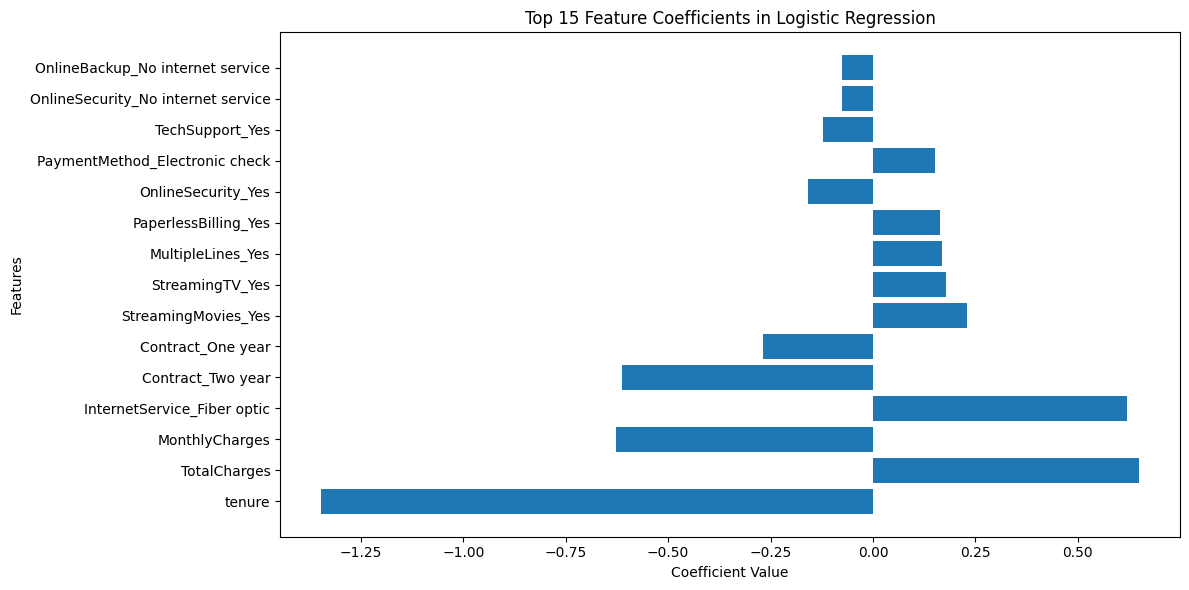

In [111]:
# 1. Import necessary libraries (if not already imported)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 2. Create and fit logistic regression model
# (using your already preprocessed and scaled data)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# 3. Make predictions
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# 4. Print model performance
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 5. Create coefficient interpretation dataframe
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': log_reg.coef_[0],
    'Odds_Ratio': np.exp(log_reg.coef_[0])  # Convert log-odds to odds ratios
})

# Sort by absolute coefficient value
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Most Important Features:")
print(coefficients[['Feature', 'Coefficient', 'Odds_Ratio']].head(10))

# 6. Visualize coefficients
plt.figure(figsize=(12, 6))
plt.barh(coefficients['Feature'].head(15), coefficients['Coefficient'].head(15))
plt.title('Top 15 Feature Coefficients in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

code source: Claude Sonnet 3.0

The model has 82% accuracy and is pretty good at predicting people who won't churn but is not as good at predicting those who will churn.

Positive Coefficients (increase churn risk):

TotalCharges (0.649427)
InternetService_Fiber optic (0.619853)
StreamingMovies_Yes (0.228714)
StreamingTV_Yes (0.179380)

Negative Coefficients (decrease churn risk):

Tenure (-1.347355)
MonthlyCharges (-0.628014)
Contract_Two_year (-0.613702)
Contract_One_year (-0.268336)

## **Building a GAM Model **

In [137]:
!pip install pygam --quiet

In [121]:
telco_churn_data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [138]:
# Initilize GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))

# Find best smoothing parameters for each spline term
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test_scaled)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


GAM MSE: 0.1347, R^2: 0.3080
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     36.1835
Link Function:                     IdentityLink Log Likelihood:                                -13809.6288
Number of Samples:                         5634 AIC:                                            27693.6246
                                                AICc:                                           27694.1321
                                                GCV:                                                0.1445
                                                Scale:                                              0.1428
                                                Pseudo R-Squared:                                   0.2724
Feature 

<ipython-input-138-f562ac886706>:19: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Code from Dr. Bent

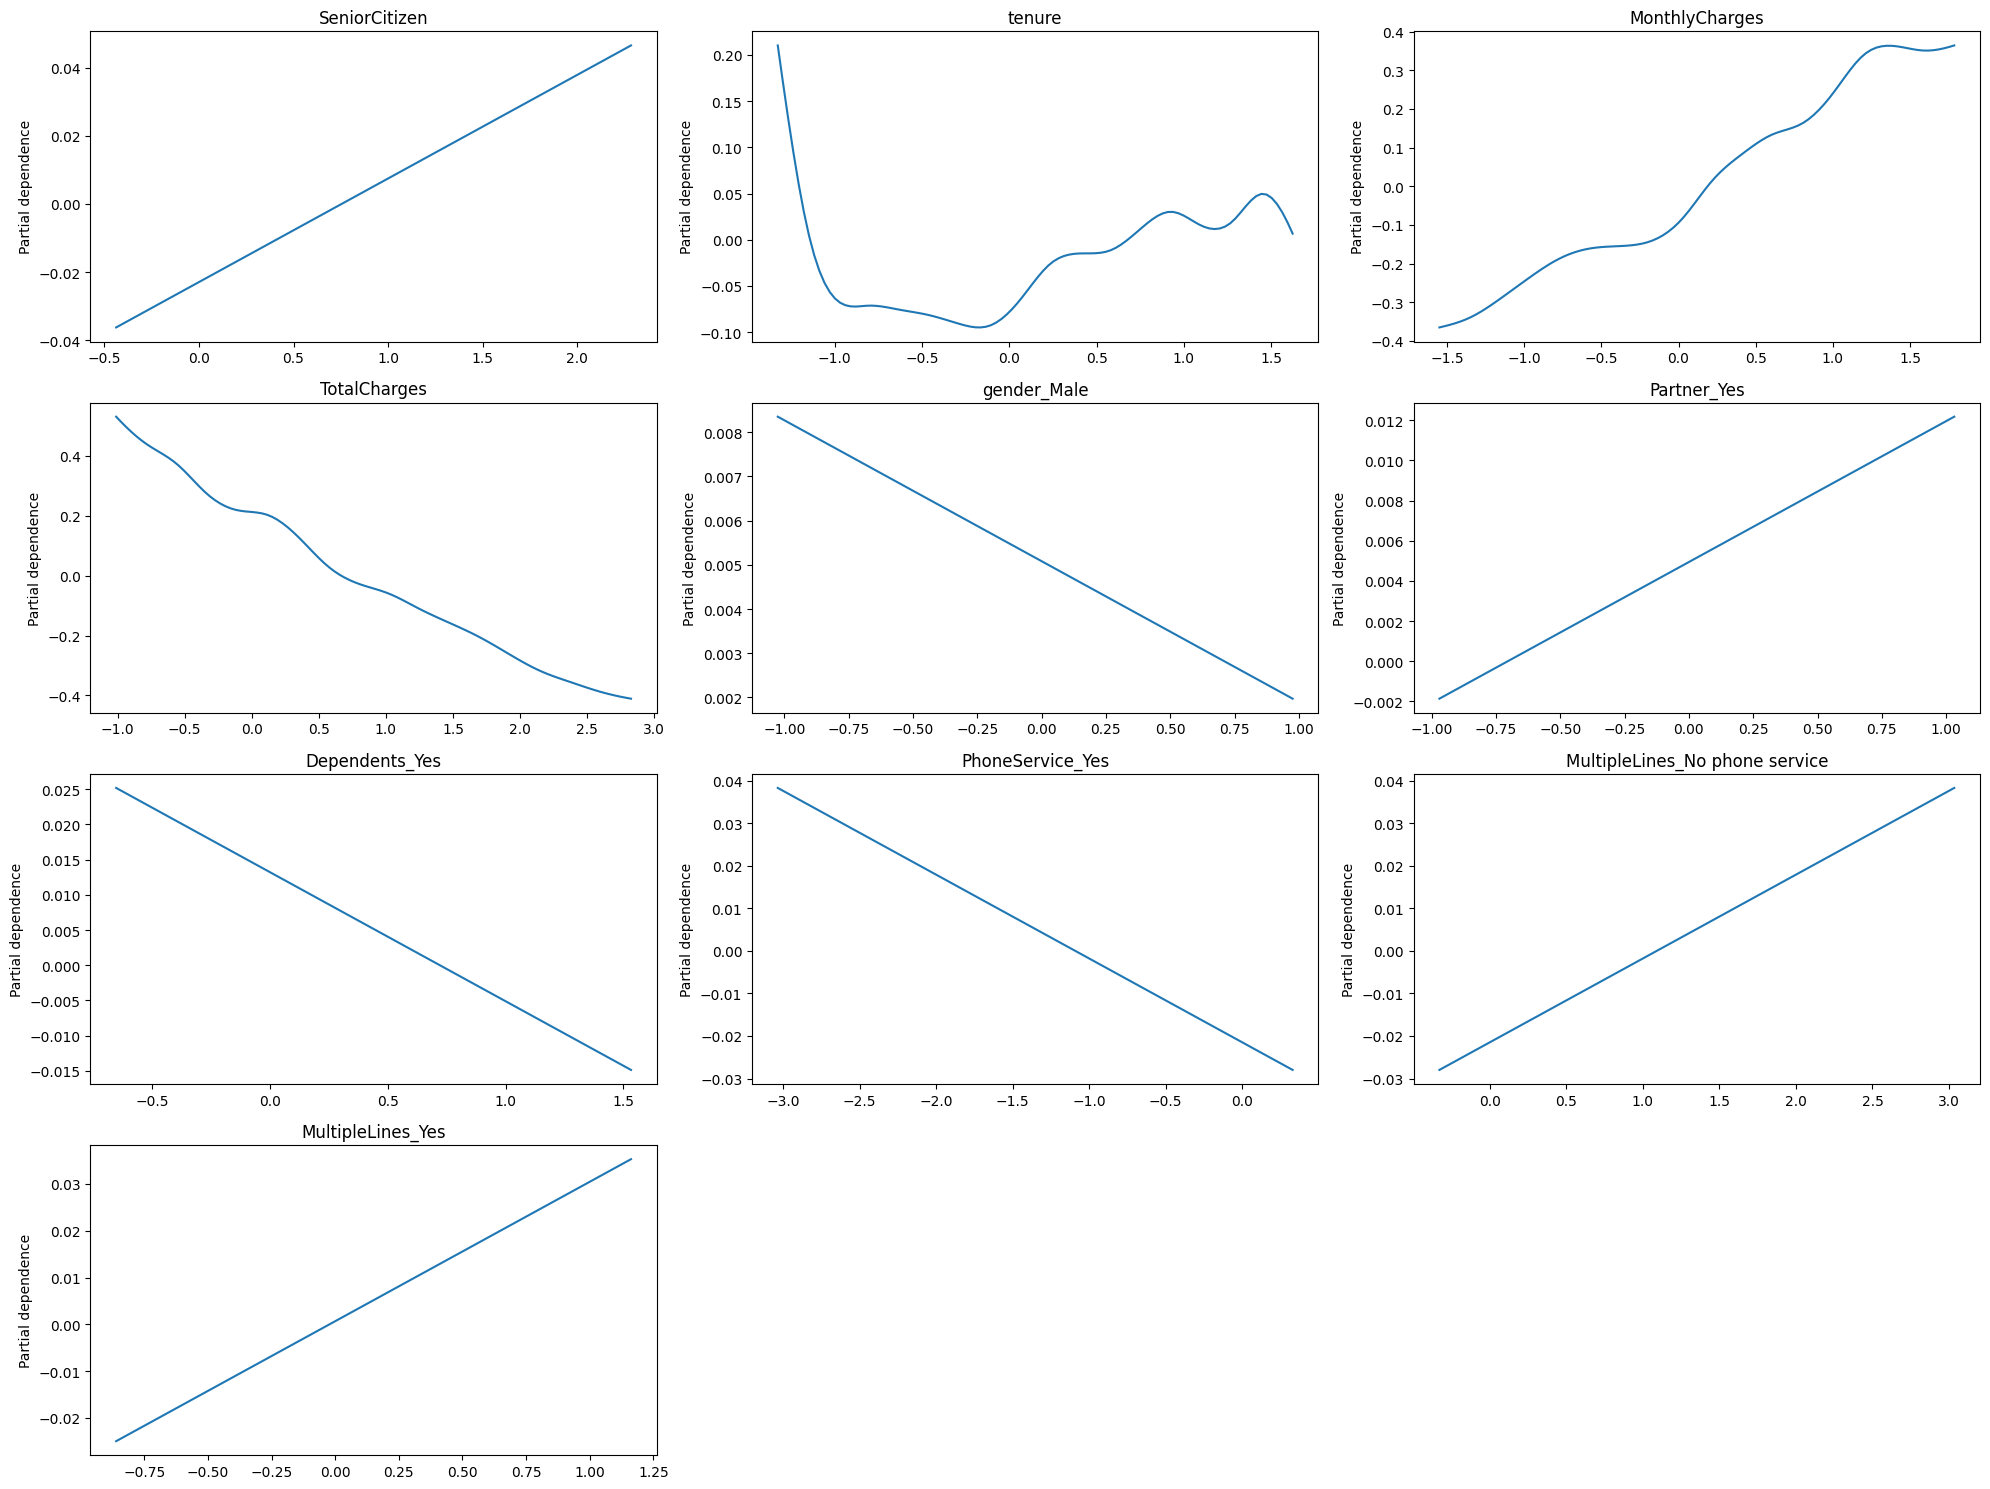

In [140]:
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

# Visualize GAM partial dependence
plt.figure(figsize=(20, 15))

# Loop through each term in the model (ignoring intercept)
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    # Generate X grid for the feature and calculate partial dependence
    XX = gam.generate_X_grid(term=i)  # No need for num_points, this is handled internally
    partial_dependence = gam.partial_dependence(term=i, X=XX)

    # Plot the partial dependence
    plt.subplot(4, 3, i+1)  # Adjust for your number of features (4x3 grid for 10 features)
    plt.plot(XX[:, term.feature], partial_dependence)
    plt.title(X.columns[i])  # Use the feature name from your data
    plt.ylabel('Partial dependence')

plt.tight_layout()
plt.show()
